In [1]:
import pandas as pd
# from IPython.display import display
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, f1_score
import csv
import seaborn as sns
import matplotlib.pyplot as plt

# read data
weather = pd.read_csv('weather_data.csv')
energy = pd.read_csv('energy_data.csv')
# display(weather.tail(), energy.head())

In [2]:
"""
1. Examine the data, parse the time fields wherever necessary. Take the sum of the energy usage
(Use [kW]) to get per day usage and merge it with weather data (10 Points).
"""
weather = weather.groupby(weather.index // 24).mean() # average the data of each hour into days
use = energy['use [kW]'].groupby(energy.index // 48).sum() # sum 'use [kW]' per every hour (2 rows)
weather['use [kW]'] = use # merge with weather
# display(weather.head(), weather.tail())

In [3]:
"""
2. Split the data obtained from step 1, into training and testing sets. The aim is to predict the usage
for each day in the month of December using the weather data, so split accordingly. The usage as
per devices should be dropped, only the “use [kW]” column is to be used for prediction from the
dataset (5 points).
"""
not_december = weather.head(-31)  # training set
december = weather.tail(31)       # testing set
# print(len(not_december), len(december))

In [4]:
"""
3. Linear Regression - Predicting Energy Usage:
Set up a simple linear regression model to train, and then predict energy usage for each day in the
month of December using features from weather data (Note that you need to drop the “use [kW]”
column in the test set first). How well/badly does the model work? (Evaluate the correctness of
your predictions based on the original “use [kW]” column). Calculate the Root mean squared error
of your model.
Finally generate a csv dump of the predicted values. Format of csv: Two columns, first should be
the date and second should be the predicted value. (20 points)
"""
linreg = LinearRegression() # initialize simple linear regression model

# use temperature to predict use [kW]
param = ['temperature']
x = not_december[param]
y = not_december['use [kW]']
linreg.fit(x, y)
prediction = linreg.predict(december[param])
# print(prediction)

# calculate root mean squared error
error = mean_squared_error(december['use [kW]'], prediction) ** 0.5
print('Root mean squared error:', error)

date = ['2014-12-%02d' % day for day in range(1, 32)] # generate dates for the first column
rows = zip(date, prediction) # zip date and predition into rows

# generate csv for predicted values
with open('energy_prediction.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['date', 'use [kW]']) # name columns
    w.writerows(rows)

Root mean squared error: 7.224497564428236


In [5]:
"""
4. Logistic Regression - Temperature classification:
Using only weather data we want to classify if the temperature is high or low. Let's assume
temperature greater than or equal to 35 is ‘high’ and below 35 is ‘low’. Set up a logistic regression
model to classify the temperature for each day in the month of December. Calculate the F1 score
for the model.
Finally generate a csv dump of the classification (1 for high, 0 for low)
Format: Two columns, first should be the date and second should be the classification (1/0).
(20 points)
"""
logreg = LogisticRegression(max_iter=500) # initialize multiple logistic regression model

# use weather data to classify temperature
param = ['humidity', 'visibility', 'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability']
x = not_december[param]
y = not_december['temperature'].map(lambda x: 1 if x >= 35 else 0)
logreg.fit(x, y)
prediction = logreg.predict(december[param])
# print(prediction)

# calculate f1 score
score = f1_score(december['temperature'].map(lambda x: 1 if x >= 35 else 0), prediction)
print('F1 score:', score)

date = ['2014-12-%02d' % day for day in range(1, 32)] # generate dates for the first column
rows = zip(date, prediction) # zip date and predition into rows

# generate csv for predicted values
with open('temperature_prediction.csv', 'w') as f:
    w = csv.writer(f)
    w.writerow(['date', 'temperature']) # name columns
    w.writerows(rows)

F1 score: 0.6486486486486487


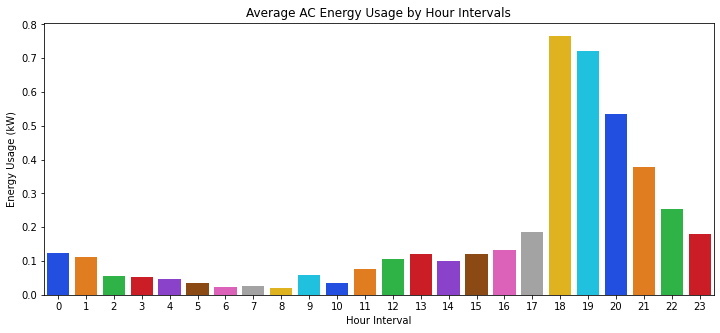

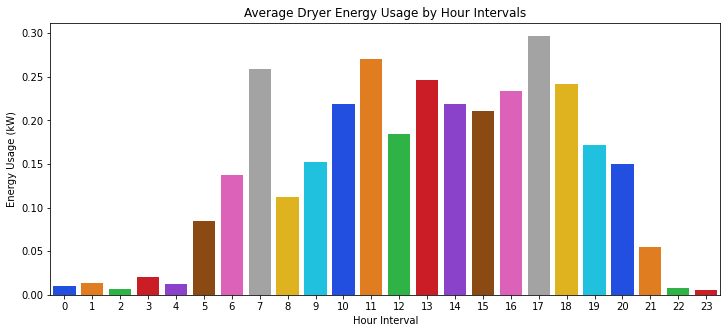

In [6]:
"""
5. Energy usage data Analysis:
We want to analyze how different devices are being used in different times of the day.
- Is the washer being used only during the day?
- During what time of the day is AC used most?
There are a number of questions that can be asked.
For simplicity, let’s divide a day in two parts:
- Day: 6AM - 7PM
- Night: 7PM - 6AM
Analyze the usage of any two devices of your choice during the ‘day’ and ‘night’. Plot these
trends. Explain your findings. (10 points)

The meaning of "day" and "night" can vary. For example, in one case, "day" can mean the
times when the sun is out and "night" can mean when the sun is not out. In another case,
"day" can mean the times when a person is awake while "night" is when they're asleep. As per
professor's comment on Piazza question @56 "It is up to you, please mention your assumptions
in the HW submission and double check with your grader about it.", I will analyze the energy
usage of different devices in different times of the day without being too strict on the
definitions of "day" and "night".

For AC, the hours with the highest usages are from 17 (5 pm) to 23 (11 pm) inclusive. The
usages are especially high from 18 (6 pm) to 20 (8 pm), and there is a sudden increase from
17 to 18. This suggests that many people go home around this time and turn on their AC to
cool off their home. A reason why so many people go home around this time is that they just
got off work. The high energy usage continues until around midnight, when people usually go
to sleep. Energy usage in the day time is fairly low compared to night time, since people
are not at home during the day.

For Dryer, there is an obvious trend that energy usage are crowded around the day time, when
most people are awake. It makes sense that people generally do laundry when they are awake,
so that they can fold their clothes after they're done being dried. This explains why the
energy usage decreases around 21 (9 pm), since it is probably too late to be doing laundry.
From 22 (10 pm) to 4 (4 am), it is reasonable that the energy usages are low, since most
people are asleep around those hours.
"""
# group 30 min intervals into 1 hour intervals, then sum by different hours
energy = energy.groupby(energy.index // 2).sum().groupby(energy.index[:len(energy.index)//2] % 24).mean()

# selecting AC and Dryer to analyze
energy = energy[['AC [kW]', 'Dryer + egauge [kW]']]

# plot for AC
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=energy.index, y='AC [kW]', data=energy, palette='bright', ax=ax)
plt.title('Average AC Energy Usage by Hour Intervals')
ax.set_xlabel('Hour Interval')
ax.set_ylabel('Energy Usage (kW)')
plt.show()

# plot for dryer
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=energy.index, y='Dryer + egauge [kW]', data=energy, palette='bright', ax=ax)
plt.title('Average Dryer Energy Usage by Hour Intervals')
ax.set_xlabel('Hour Interval')
ax.set_ylabel('Energy Usage (kW)')
plt.show()

In [7]:
"""
6. Visual Appeal and Layout - For all the tasks above, please include an explanation wherever
asked and make sure that your procedure is documented (suitable comments) as good as you can.
Don’t forget to label all plots and include legends wherever necessary as this is key to making
good visualizations! Ensure that the plots are visible enough by playing with size parameters. Be
sure to use appropriate color schemes wherever possible to maximize the ease of understandability.
Everything must be laid out in a python notebook (.ipynb). (5 Point)
"""

'\n6. Visual Appeal and Layout - For all the tasks above, please include an explanation wherever\nasked and make sure that your procedure is documented (suitable comments) as good as you can.\nDon’t forget to label all plots and include legends wherever necessary as this is key to making\ngood visualizations! Ensure that the plots are visible enough by playing with size parameters. Be\nsure to use appropriate color schemes wherever possible to maximize the ease of understandability.\nEverything must be laid out in a python notebook (.ipynb). (5 Point)\n'